# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**The key business objective is to understand and identify the important features in an used car, that can help sales teams in car dealerships to identify the types of used cars that should be kept in an inventory to maximize sales.**

**A used car dealership works on the principle that the vehicle they acquire, should sell for a profit. Therefore its important to be able to predict the final sale price of a car based on its characteristics. This can help dealers make buying decisions and also decide the price of the used car , which they buy for further selling.**

**While maximizing profit is one of the important goals, another factor is to identify market demand also and purchase the right cars that can be easily resold.** 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import RobustScaler,OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [2]:
# Set display options 
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [3]:
# Reading the CSV into a data frame 
df = pd.read_csv('data/vehicles.csv')
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
df.shape

(426880, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [6]:
# Check for missing values
# Find columns with na count more than 0
(df.isna().sum() / len(df) * 100)[df.isna().sum() >0]

year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
dtype: float64

In [7]:
# Check for duplicate values 
dup_count = df.duplicated().sum()
print ("number of duplicate rows",dup_count)

number of duplicate rows 0


### Type Correction

In [8]:
# Extract number of cylinders and convert to number
df['cylinders'] = df['cylinders'].astype('string')
df['cylinders'] = df['cylinders'].str.extract(r'(\d+)')
df['cylinders'] = df['cylinders'].astype('float')

# Covert year and odometer to integer instead of float 
df['year'] = df['year'].astype('Int64')
df['odometer'] = df['odometer'].astype('Int64')

### Imputation

In [9]:
#since there are no duplicate rows , lets drop columns with large missing 
# values such as size or columns without impact such as VIN 

drop_cols = ["VIN","size"]
existing_cols = df.columns.intersection(drop_cols)
df = df.drop(columns=existing_cols)

In [10]:
# Year has ~0.3% missing values. Add an imputation strategy with medians 
df['year'] = df['year'].fillna(df['year'].median())

# Odometer has ~1% missing values. Add an imputation strategy with medians 
df['odometer'] = df['odometer'].fillna(df['odometer'].median())

# fuel and transmission are categorical columns , lets use imputation stratgey with mode
df['fuel'] = df['fuel'].fillna(df['fuel'].mode()[0])
df['transmission'] = df['transmission'].fillna(df['transmission'].mode()[0])

# Add a new category called unknown to title_status, drive, type, condition and paint color
df.loc[df['title_status'].isna(), 'title_status'] = 'Unknown'
df.loc[df['drive'].isna(), 'drive'] = 'Unknown'
df.loc[df['paint_color'].isna(), 'paint_color'] = 'Unknown'
df.loc[df['type'].isna(), 'type'] = 'Unknown'
df.loc[df['condition'].isna(), 'condition'] = 'Unknown'

# Drop rows where model column is missing
df = df.dropna(subset=['model'])

# Drop rows where manufacturer column is missing
df = df.dropna(subset=['manufacturer'])

In [11]:
# Use a hierarchial fallback strategy for cylinders
df['cylinders'] = df.groupby(['manufacturer', 'fuel', 'year'])['cylinders'].transform(lambda x: x.fillna(x.median()))

# Fill remaining NaNs grouped by manufacturer, fuel
df['cylinders'] = df.groupby(['manufacturer', 'fuel'])['cylinders'].transform(lambda x: x.fillna(x.median()))

# Fill any remaining NaNs with overall median
df['cylinders'] = df['cylinders'].fillna(df['cylinders'].median())


In [12]:
#Check no more missing values are present 
# Find columns with na count more than 0
(df.isna().sum() / len(df) * 100)[df.isna().sum() >0]

Series([], dtype: float64)

## Data Validation and further cleanup

In [13]:
# Describe the data to observe anamolies

# Some rows have price 0 lets remove them
df = df[df['price'] > 0]

# Some rows have odometer 0 readings. Since these are used cars lets remove them
df = df[df['odometer'] > 0]

df.shape

(372269, 16)

## Data Visualization

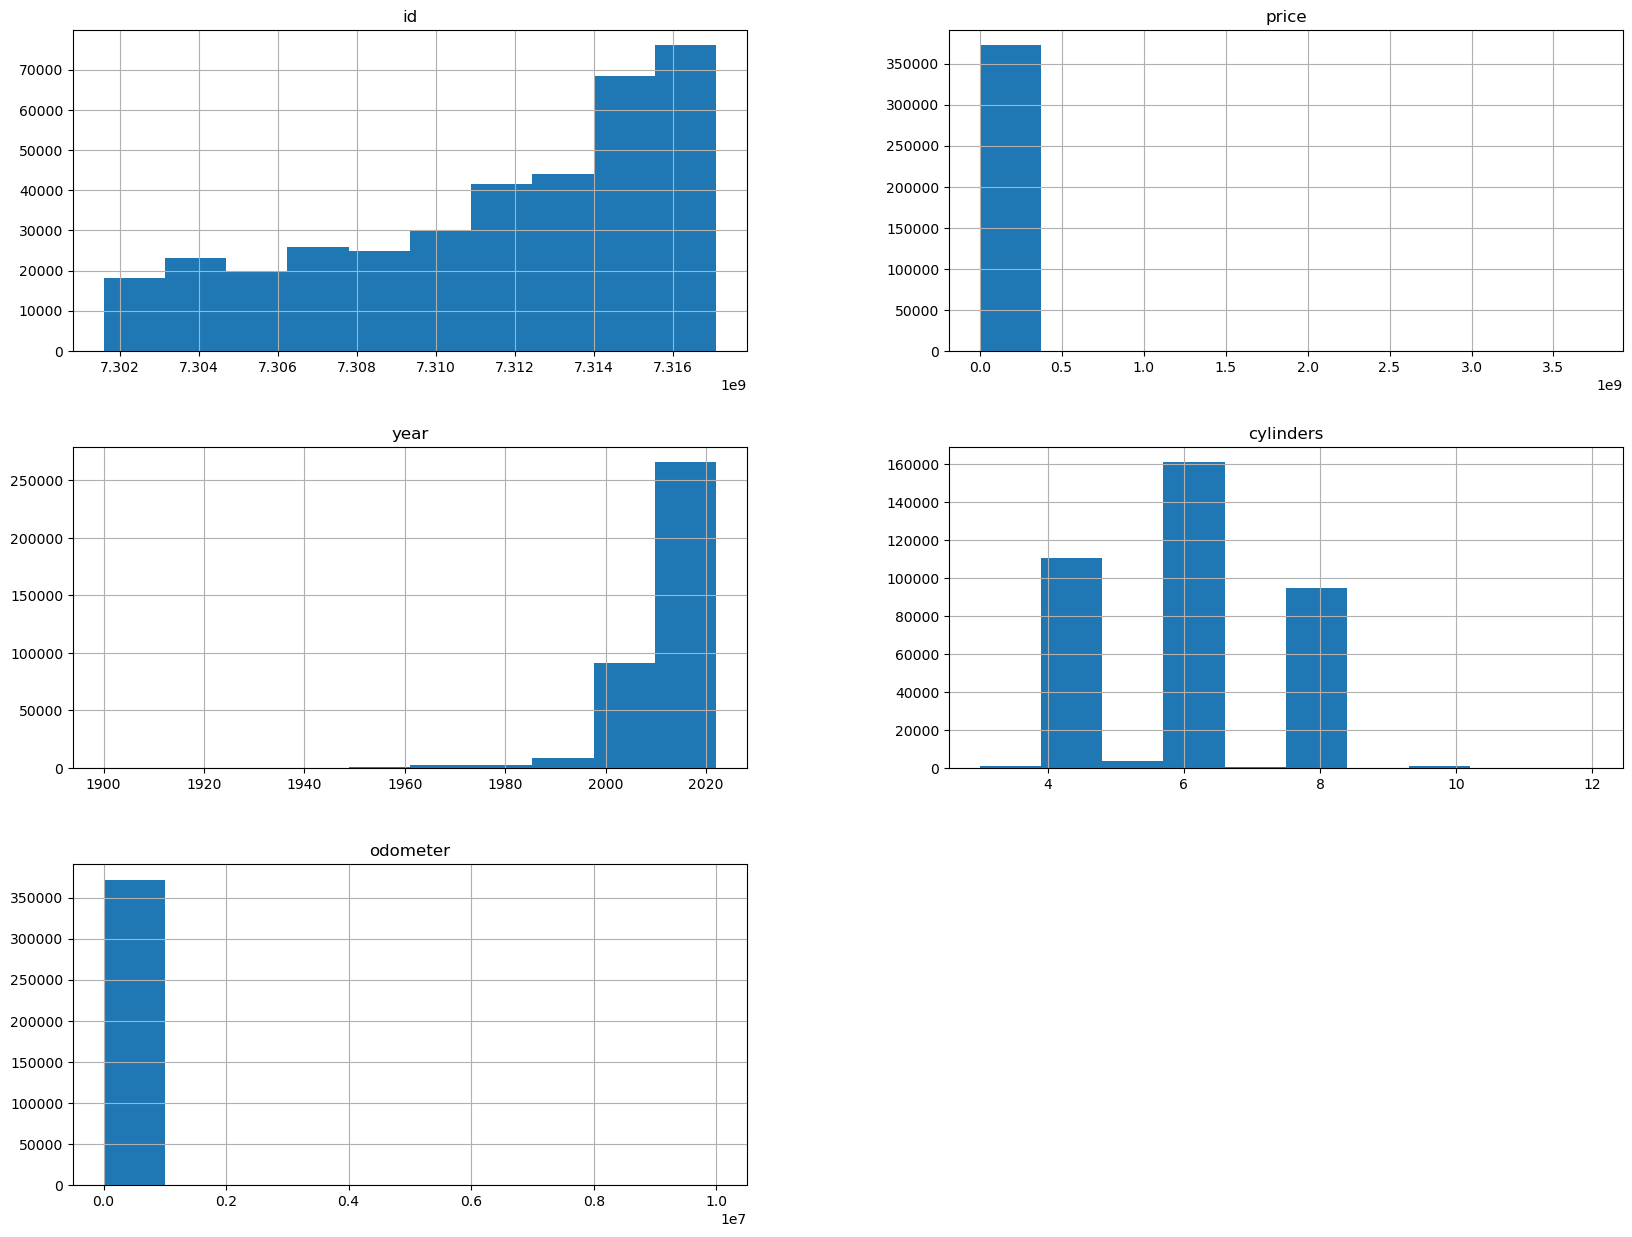

In [14]:
# Plot a histogram of numerical columns 
df.hist(figsize=(20,15));
plt.savefig("images/histograms.png", dpi =300)
plt.show()

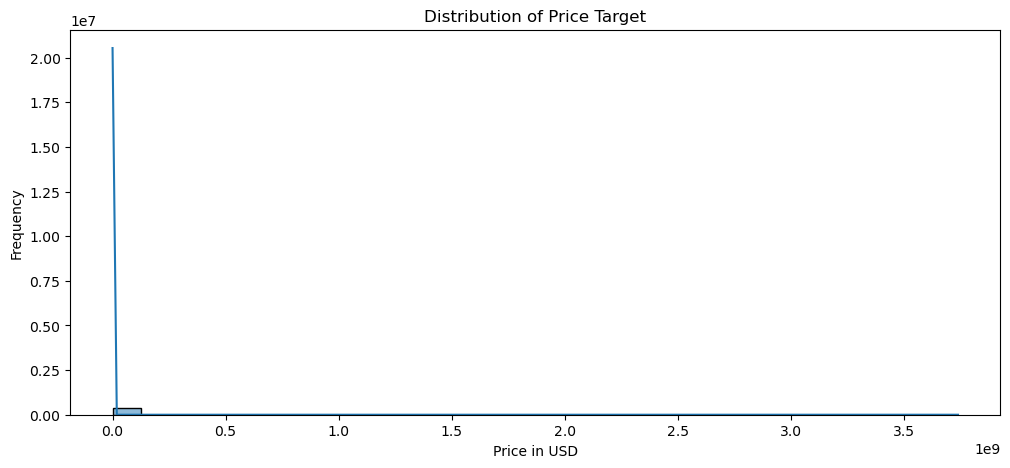

In [15]:
# Plot distribution of target(price) using a histogram
plt.figure(figsize=(12, 5))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Distribution of Price Target')
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.savefig("images/price_distribution_pre_outliers.png", dpi =300)
plt.show()

In [16]:
# Descibe the price column
df['price'].describe()

# The max is 3.7 billion $ which is an outlier anamoly and perhaps an error 

count    3.722690e+05
mean     6.745525e+04
std      1.171216e+07
min      1.000000e+00
25%      7.490000e+03
50%      1.550000e+04
75%      2.759000e+04
max      3.736929e+09
Name: price, dtype: float64

In [17]:
# Lets perform IQR and remove the outliers 

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = ((df['price'] < lower_bound) | (df['price'] > upper_bound)).sum()
print(f"Number of outliers found: {outliers:,}")

# Remove outliers
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

df.shape

Number of outliers found: 6,899


(365370, 16)

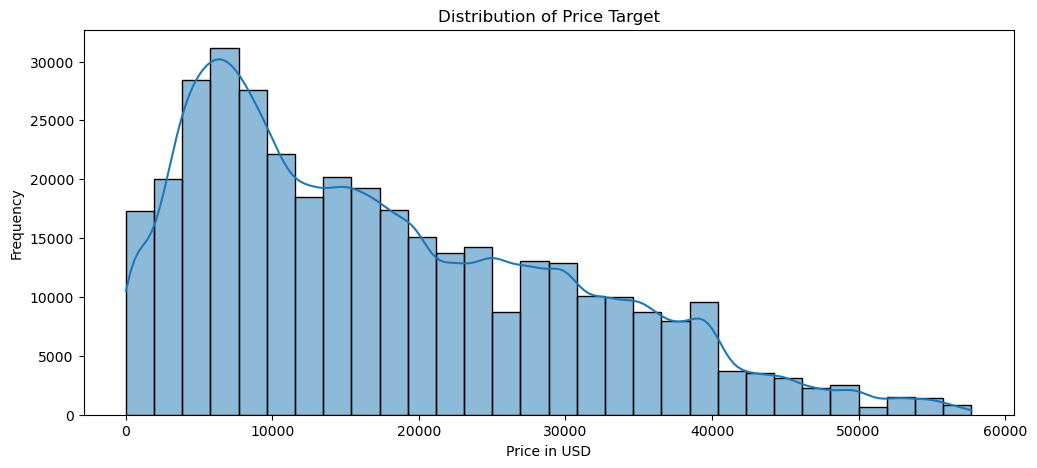

In [18]:
# Plot distribution of target(price) using a histogram post cleanup of outliers
plt.figure(figsize=(12, 5))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Distribution of Price Target')
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.savefig("images/price_distribution_post_outliers.png", dpi =300)
plt.show()

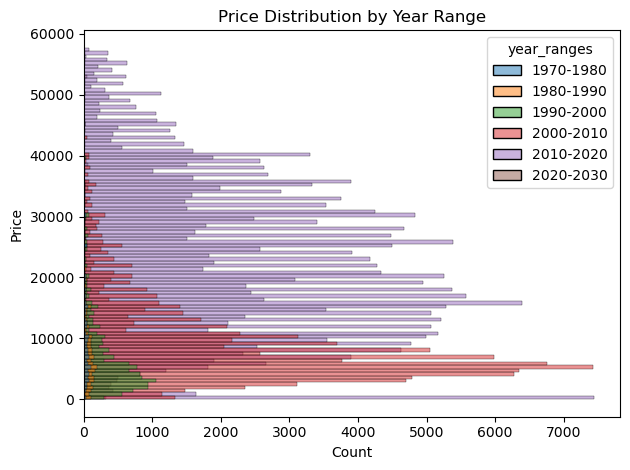

In [19]:
# Show plot of year vs price 
# We need to create ranges for years 
year_range_labels = ['1970-1980', '1980-1990', '1990-2000',
                     '2000-2010', '2010-2020', 
                     '2020-2030']

df['year_ranges'] = pd.cut(df['year'], bins=range(1970, 2040, 10), 
                        labels=year_range_labels)

sns.histplot(
    data=df,
    y='price',
    hue='year_ranges'
)
plt.title('Price Distribution by Year Range')
plt.ylabel('Price')
plt.xlabel('Count')

plt.tight_layout()
plt.savefig("images/price_distribution_by_year.png", dpi =300)
plt.show()
df.drop(['year_ranges'], axis=1, inplace=True)


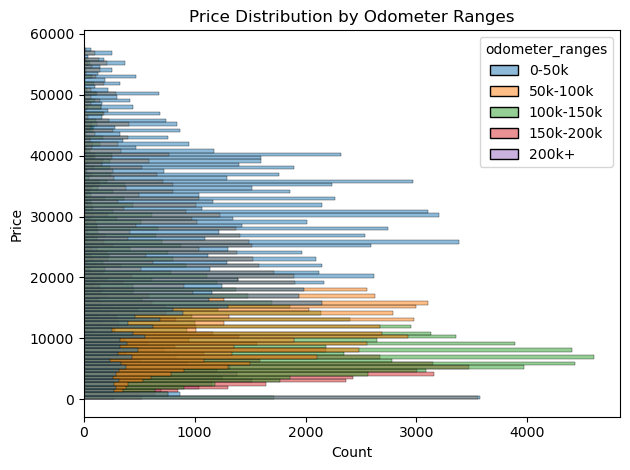

In [20]:
# Show plot of odometer reading vs price
# We need to create ranges for odometer readings 
odometer_range_labels = ['0-50k', '50k-100k', '100k-150k', '150k-200k', '200k+']

df['odometer_ranges'] = pd.cut(
    df['odometer'],
    bins=[0, 50000, 100000, 150000, 200000, df['odometer'].max()],
    labels=odometer_range_labels
)

sns.histplot(
    data=df,
    y='price',
    hue='odometer_ranges'
)
plt.title('Price Distribution by Odometer Ranges')
plt.ylabel('Price')
plt.xlabel('Count')

plt.tight_layout()
plt.savefig("images/price_distribution_by_odometer.png", dpi =300)
plt.show()
df.drop(['odometer_ranges'], axis=1, inplace=True)

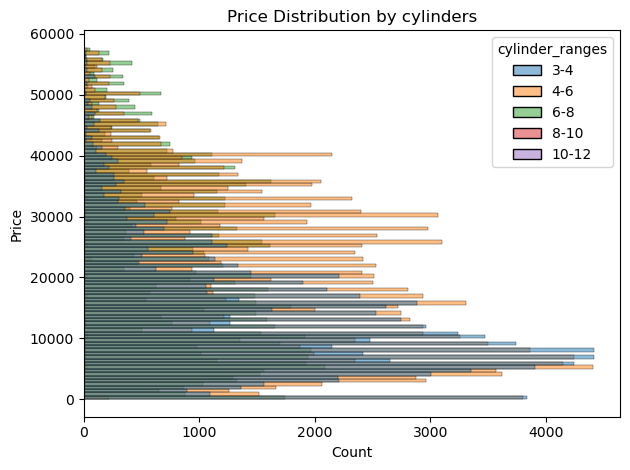

In [21]:
# Show plot of price vs cylinders 

# We need to create ranges for cylinders
cylinder_range_labels = ['3-4', '4-6', '6-8', '8-10', '10-12']

df['cylinder_ranges'] = pd.cut(
    df['cylinders'],
    bins=[3.0, 4.0, 6.0, 8.0, 10.0, 12.0],
    labels=cylinder_range_labels
)
sns.histplot(
    data=df,
    y='price',
    hue='cylinder_ranges'
)
plt.title('Price Distribution by cylinders')
plt.ylabel('Price')
plt.xlabel('Count')

plt.tight_layout()
plt.savefig("images/price_distribution_by_cylinders.png", dpi =300)
plt.show()
df.drop(['cylinder_ranges'], axis=1, inplace=True)

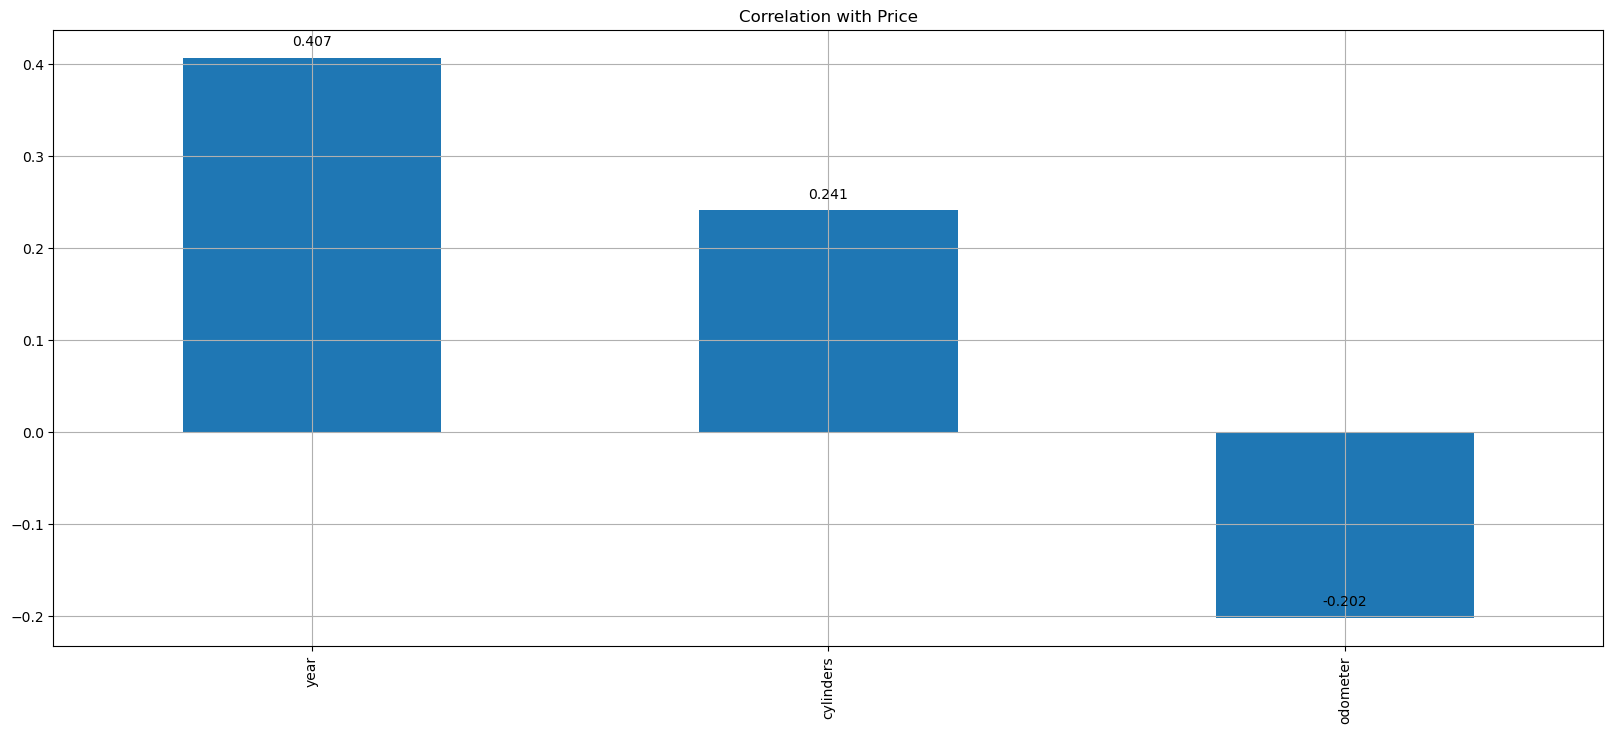

In [22]:
# Correlation of price with all numeric features 
numeric_features =['year','cylinders','odometer']
corelations=df.drop('price', axis=1)[numeric_features].corrwith(df['price'])
ax=corelations.plot(kind='bar', grid=True, figsize=(20, 8)
, title="Correlation with Price")
for i, (idx, val) in enumerate(corelations.items()):
    ax.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=10)
plt.savefig("images/numeric_corelation.png", dpi =300)
plt.show()

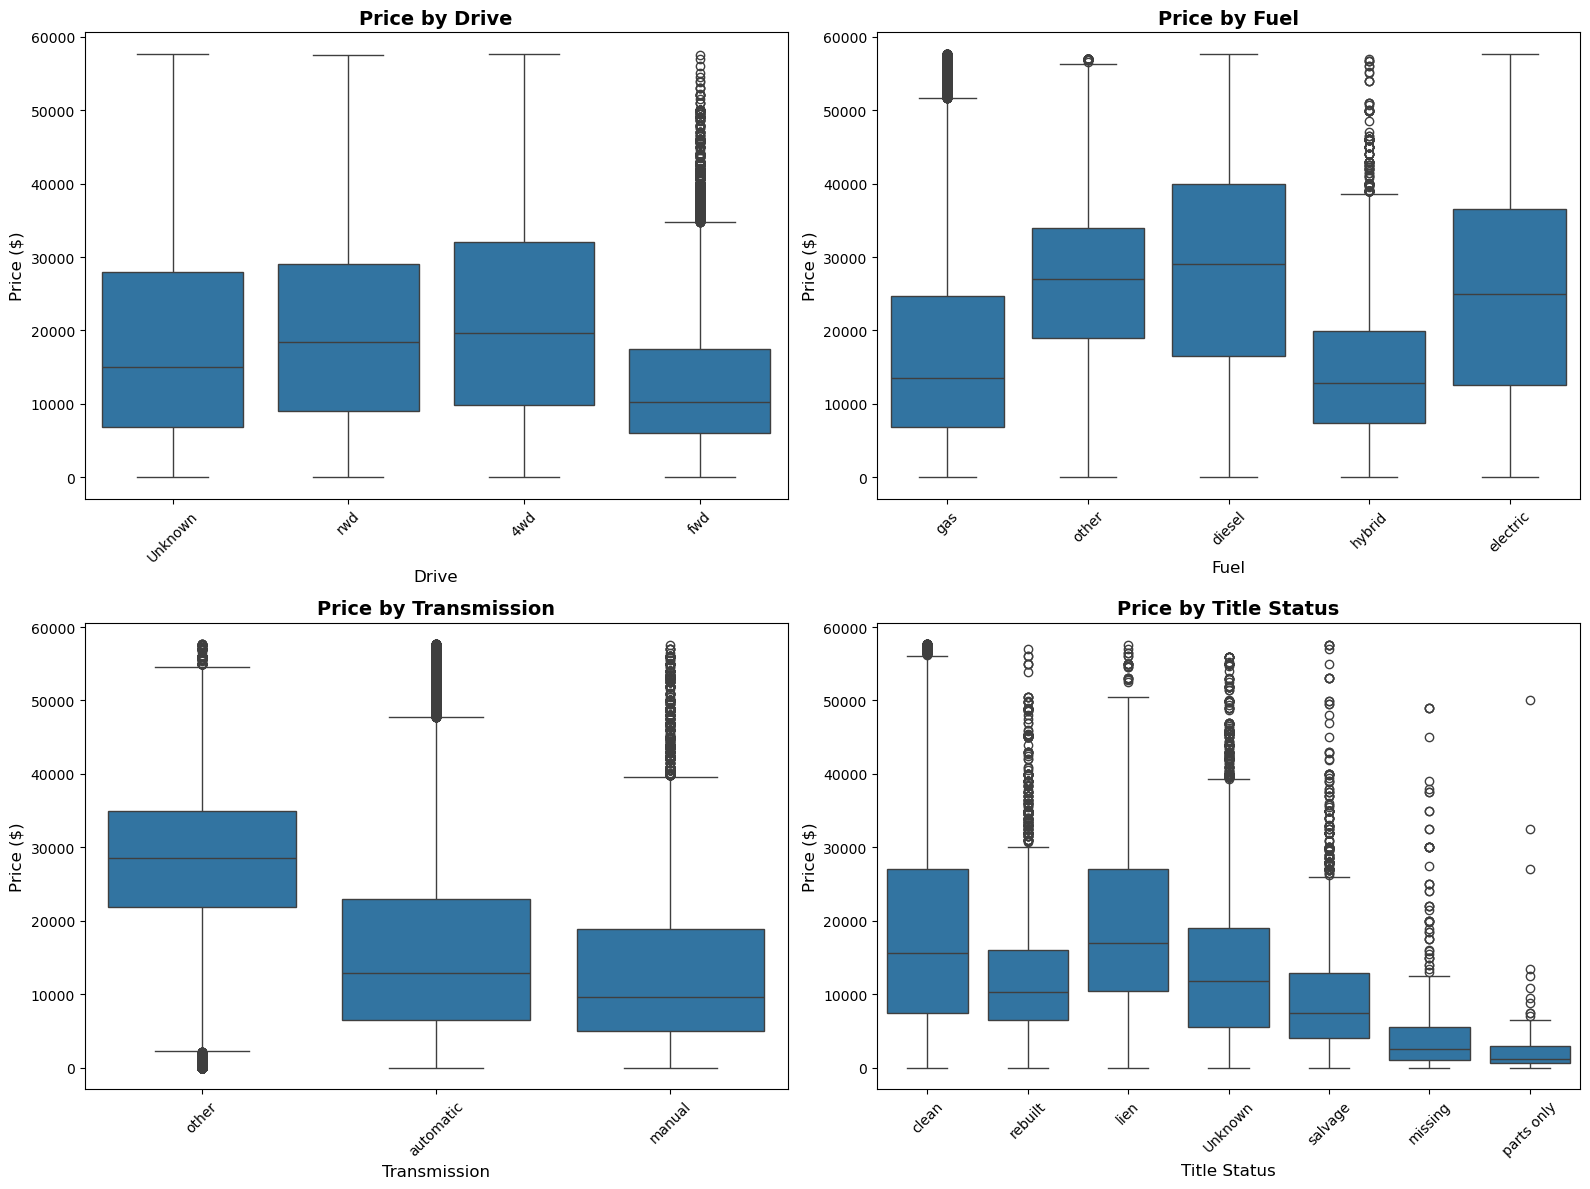

In [23]:
# Create a box plot of categorical features to show distribution
categorical_features=['drive', 'fuel', 'transmission', 'title_status']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, var in enumerate(categorical_features):
    sns.boxplot(data=df, x=var, y='price', ax=axes[idx])
    
    # Format title (capitalize and replace underscore)
    title = var.replace('_', ' ').title()
    axes[idx].set_title(f'Price by {title}', fontsize=14, fontweight='bold')
    
    # Format labels
    axes[idx].set_xlabel(title, fontsize=12)
    axes[idx].set_ylabel('Price ($)', fontsize=12)
    
    # Rotate x-axis labels for readability
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('images/price_by_categories.png', dpi=300, bbox_inches='tight')
plt.show()


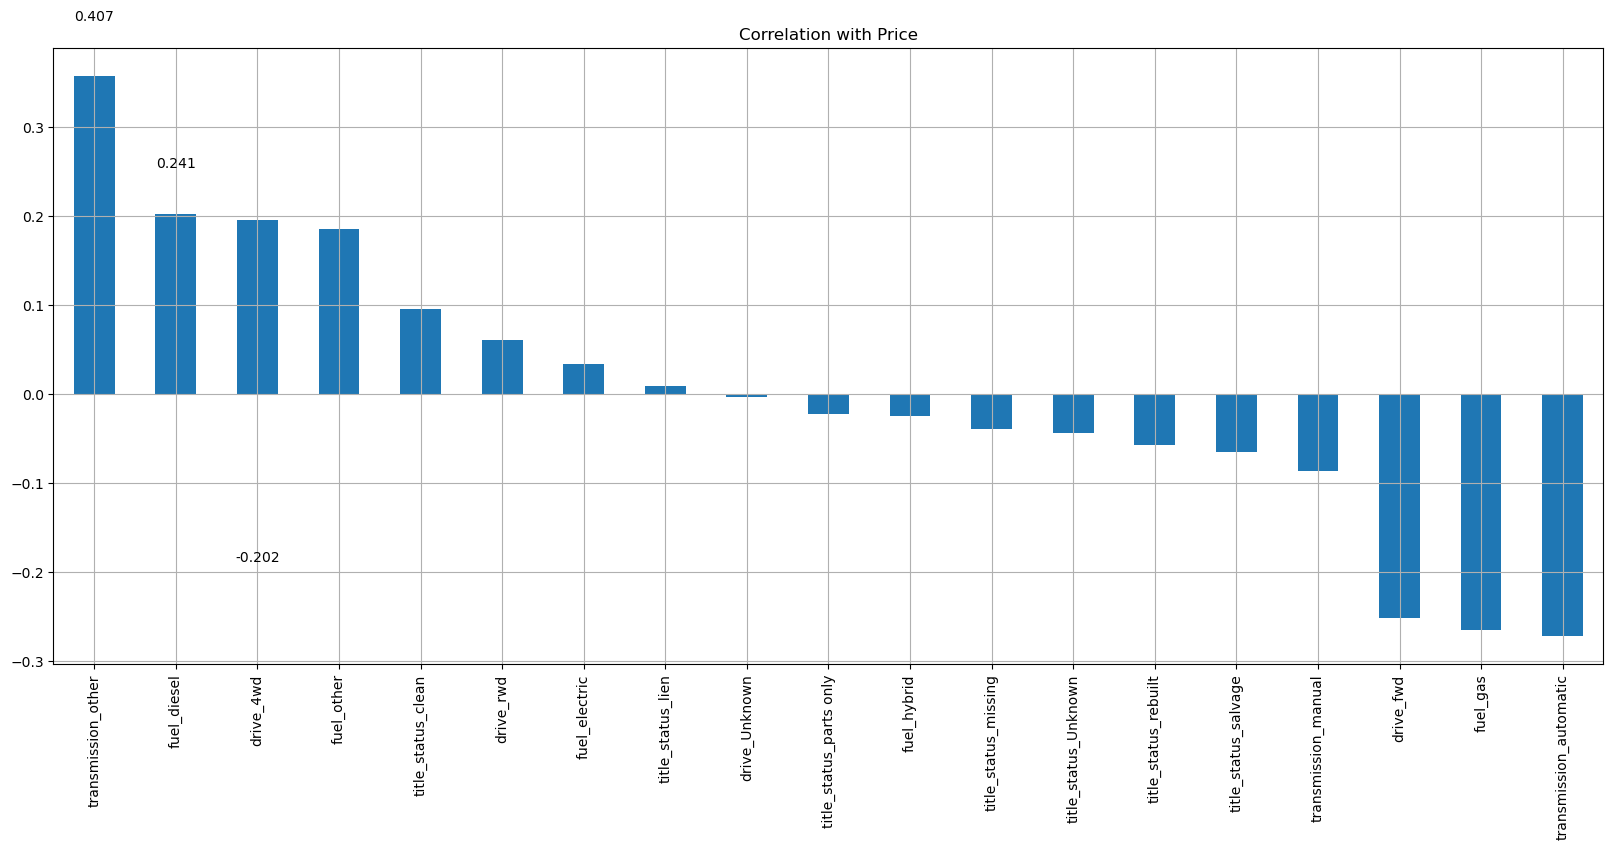

In [24]:
# Correlation of price with categorical features
categorical_features=['drive', 'fuel', 'transmission', 'title_status']

#Since categorical features are not encoded, we will hot encode them 

df_encoded = pd.get_dummies(df[categorical_features], drop_first=False)
correlations = df_encoded.corrwith(df['price']).sort_values(ascending=False)

ax=correlations.plot(kind='bar', grid=True, figsize=(20, 8)
, title="Correlation with Price")
for i, (idx, val) in enumerate(corelations.items()):
    ax.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=10)
plt.savefig("images/categorical_corelation.png", dpi =300)
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [25]:
# Drop id column as it has no impact over modelling 
if 'id' in df.columns:
    df = df.drop('id', axis=1)

In [26]:
# We have a mix of numerical and categorical features 
numerical_features = ['year', 'cylinders', 'odometer']

# We imputed during cleanup and will only use a Scaler now
numerical_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])
#Lets drop region and model columns for consideration in the model
categorical_features = ['fuel','transmission','drive','title_status','type', 
                        'manufacturer','paint_color','state']
# We imputed during cleanup and will only use a encoder now
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(
        handle_unknown='ignore', 
        sparse_output=False,
        max_categories=15,
        drop='first'
    ))
])


# Since condition has natural encoding , we will use an ordinal encoder
ordinal_features = ['condition']
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(
        categories=[['salvage', 'fair', 'good', 'excellent', 'like new', 'new']],
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

# Create a pre-processor with all the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_transformer', numerical_transformer, numerical_features),
        ('categorical_transformer', categorical_transformer, categorical_features),
        ('ordinal_transformer', ordinal_transformer,ordinal_features )
    ],
    remainder='drop',
    verbose_feature_names_out=False
)


In [27]:
# Test train split the data 

# baseline features are our numerical, categorical and ordinal features
baseline_features = numeric_features + categorical_features + ordinal_features 


X = df[baseline_features]
y = df['price']

# 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42
)




In [34]:
# Lets create a map of regression models we will evaluate 
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42)
}

# placeholder for results
results=[]

for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train pipeline
    pipeline.fit(X_train, y_train)
    
    # Predict values
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate metrics(RMSE, MAE and R2)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    trainr2 = r2_score(y_train, y_train_pred)
    testr2 = r2_score(y_test, y_test_pred)
    
    # Store results
    results.append({
        'Model': name,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R2': trainr2,
        'Test R2': testr2,
    })
    # Coefficients for the model
    fitted_model = pipeline.named_steps['model']
    if hasattr(fitted_model, 'coef_'):
        print("Finding coefficients for the model",name)
        # Get all feature names from the preprocessor
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
        
        # Create coefficient series
        coeffs = pd.Series(fitted_model.coef_, index=feature_names).sort_values(key=abs, ascending=False)
        print(coeffs.head(10))  # Print top 10 coefficients
    else:
        print("Model does not have coefficients")
results_df = pd.DataFrame(results)
results_df

Finding coefficients for the model Linear Regression
fuel_gas               -8715.711971
transmission_other      7848.278273
fuel_hybrid            -7823.923850
fuel_other             -7341.677259
title_status_missing    6859.733752
drive_fwd              -5240.245232
title_status_lien       5019.403153
year                    4980.417633
cylinders               4391.729458
type_convertible        4379.101178
dtype: float64
Finding coefficients for the model Ridge Regression
fuel_gas               -8713.651120
transmission_other      7847.917016
fuel_hybrid            -7819.600158
fuel_other             -7338.980300
title_status_missing    6841.739863
drive_fwd              -5240.175392
title_status_lien       5012.146349
year                    4980.282280
cylinders               4391.821243
type_convertible        4377.938586
dtype: float64
Finding coefficients for the model Lasso Regression
fuel_gas               -8633.992218
transmission_other      7824.788950
fuel_hybrid          

,Model,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2
0,Linear Regression,9300.411421,9289.784904,6798.421312,6789.259621,0.463361,0.463697
1,Ridge Regression,9300.411494,9289.780646,6798.440979,6789.277920,0.463361,0.463697
2,Lasso Regression,9300.948112,9289.931522,6799.030266,6789.198471,0.463299,0.463680
3,ElasticNet,10573.409627,10560.408524,8402.815919,8384.188618,0.306402,0.306957


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

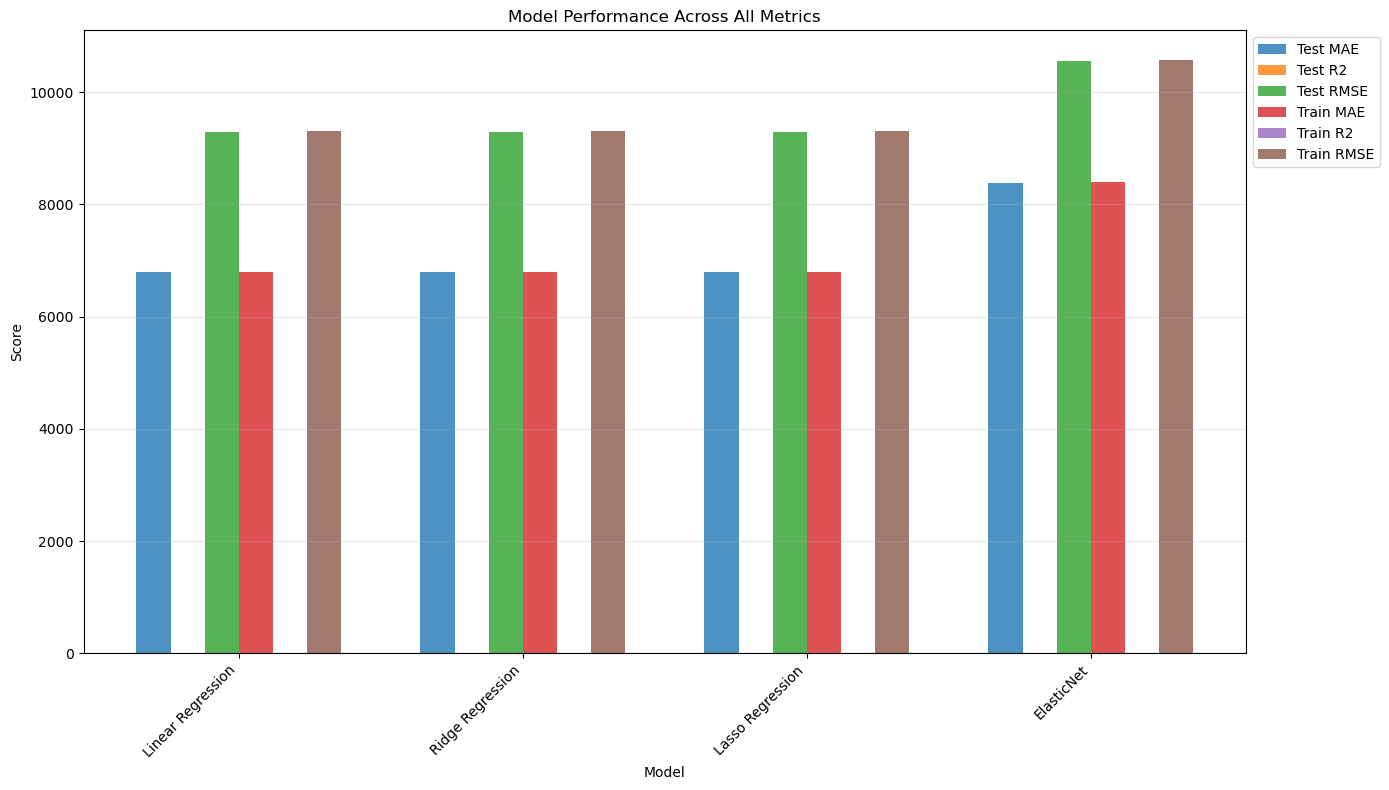

In [35]:
# Create a combined plot of model vs scores

models = results_df['Model'].tolist()

metrics = results_df.columns.difference(['Model']).tolist()

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(models))

width =0.12
for i, metric in enumerate(metrics):
    offset = width * (i - 2.5)
    ax.bar(x + offset, results_df[metric], width, label=metric, alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Across All Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0.8, color='green', linestyle='--', alpha=0.3, linewidth=1)

plt.tight_layout()
plt.savefig('images/model_metrics_combined.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# Now that we have established an initial baseline , lets optimize or tune the models using Grid SearchCV

In [36]:
# Define tuning parameters
param_grids = {
    'Linear Regression': {
        'model__fit_intercept': [True]
    },
    'Ridge Regression': {
        'model__alpha': [0.1, 1, 10, 100],
        'model__solver': ['auto', 'svd']
    },
    'Lasso Regression': {
        'model__alpha': [0.1, 1, 10, 100],
        'model__max_iter': [5000]
    },
    'ElasticNet': {
        'model__alpha': [0.1, 1, 10],  
        'model__l1_ratio': [0.3, 0.7]
    }
}

In [39]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42)
}
grid_search_results = []

for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    print("Grid search on model", name)

    # Create a Grid search
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        cv=5,  
        scoring='neg_root_mean_squared_error', 
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    
    # Train pipeline
    grid_search.fit(X_train, y_train)
    
    # Predict values
    y_train_pred = grid_search.predict(X_train)
    y_test_pred = grid_search.predict(X_test)

    # Get best params fromt the grid search
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cv_score = -grid_search.best_score_ 
    
    # Calculate metrics(RMSE, MAE and R2)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    trainr2 = r2_score(y_train, y_train_pred)
    testr2 = r2_score(y_test, y_test_pred)
    
    # Store results
    grid_search_results.append({
        'Model': name,
        'Best Params':best_params,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R2': trainr2,
        'Test R2': testr2,
    })

# Create a data frame of the results
tuned_results_df = pd.DataFrame(grid_search_results) 
tuned_results_df

Grid search on model Linear Regression
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Grid search on model Ridge Regression
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid search on model Lasso Regression
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Grid search on model ElasticNet
Fitting 5 folds for each of 6 candidates, totalling 30 fits


,Model,Best Params,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2
0,Linear Regression,{'model__fit_intercept': True},9300.411421,9289.784904,6798.421312,6789.259621,0.463361,0.463697
1,Ridge Regression,"{'model__alpha': 10, 'model__solver': 'svd'}",9300.418454,9289.748938,6798.620280,6789.442548,0.463360,0.463701
2,Lasso Regression,"{'model__alpha': 0.1, 'model__max_iter': 5000}",9300.418393,9289.750763,6798.445149,6789.224542,0.463360,0.463701
3,ElasticNet,"{'model__alpha': 0.1, 'model__l1_ratio': 0.7}",9448.887071,9431.783351,6987.654745,6972.476152,0.446090,0.447176


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

Based on visual analysis and modeling we can make the following conclusions

1. Front wheel cars fetch lower value.

2. Cars with more cylinders, or convertible types increase resale value.

3. Newer the manufacturing year or model, better the price.

4. Title status is very imporant for price determination. Please eensure necessary legal verification is done.

5. Gas powered vehicles have more selling potential over hybrid cars

6. Vehicles with automatic transmissions command higher prices over manual transmissions.